# Prices prediction with Labels

# Imports

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import shap
warnings.filterwarnings('ignore')

# Helper Functions

In [49]:
#A function that returns features that their absolute correlation is greater or equal than the provided threshold
def get_correlated_features(df_numeric, threshold):
  correlation_matrix = df_numeric.corr().abs() # Calculate absolute values in the correlation matrix of the numeric DataFrame
  unstacked_correlations = correlation_matrix.unstack() # Unstack the correlation matrix to get all pairwise correlations
  sorted_correlations = unstacked_correlations.sort_values() # Sort the correlations in ascending order
  sorted_correlations = sorted_correlations[sorted_correlations != 1 ] # Remove correlations of features with themselves (diagonal) as they're always 1
  relevant_correlations = sorted_correlations[sorted_correlations >= threshold] # Filter correlations based on the provided threshold
  unique_correlation_pairs = list(relevant_correlations.index.unique()) # Extract unique pairs of correlated features
  correlated_features = [] # Initialize a list to store correlated feature pairs
  # Iterate through unique pairs and append them to the list if not already present
  for pair in unique_correlation_pairs:
    if sorted(pair) not in correlated_features:
      correlated_features.append(sorted(pair))
  return correlated_features

def get_columns_with_many_missing_values(df, percent_missing_threshold):
  percent_missing = df.isnull().sum() * 100 / len(df) # Calculate the percentage of missing values for each column in the DataFrame
  missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}) # Create DataFrame to store column names and missing value percentages
  columns_with_missing_values = [] # Initialize list to store column names with missing values
  columns_with_many_missing_values = [] # Initialize list to store column names with many missing values
  for i in range(len(missing_value_df)):
      if missing_value_df.iloc[i,1] > percent_missing_threshold: # Check if the percentage of missing values exceeds the threshold
        columns_with_many_missing_values.append(missing_value_df.iloc[i,0]) # Add column name to list of columns with many missing values
      elif missing_value_df.iloc[i,1] > 0: # Check if there are any missing values at all
        columns_with_missing_values.append(missing_value_df.iloc[i,0]) # Add column name to list of columns with any missing values
  return columns_with_missing_values, columns_with_many_missing_values

def get_normally_distributed_columns(df, alpha):
  normally_distributed_columns = []
  for column in df_numeric:
    # Perform Shapiro-Wilk test
    data = df_numeric[column]
    statistic, p_value = stats.shapiro(data)
    # Interpret the result
    if p_value < alpha:
      # Rejected the null hypothesis, Data does not come from a normal distribution
      pass
    else:
      # Fail to reject the null hypothesis, Data may come from a normal distribution
        normally_distributed_columns.append(column)
  return normally_distributed_columns

# A function that plots bar plot of the percentages of missing values for each feature
def plot_percentages_of_missing_values(df):
    fig, ax = plt.subplots() # Create a new figure and axis object for plotting
    percent_missing = df.isnull().sum() * 100 / len(df) # Calculate percentage of missing values for each feature
    percent_missing = round(percent_missing, 2) # Round the percentage to two decimal places
    missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}) # Create DataFrame to store column names and missing value percentages
    missing_value_df = missing_value_df[missing_value_df["percent_missing"] > 0] # Filter out columns with 0% missing values
    colors = [] # Initialize list for bar colors
    for i in range(len(missing_value_df)):
        if missing_value_df.iloc[i, 1] > 10: # Check if percentage of missing values is greater than 10%
            colors.append("red") # Assign red color for high missing percentage
        else:
            colors.append("green") # Assign green color for low missing percentage
    bars = plt.bar(missing_value_df["column_name"], missing_value_df["percent_missing"], color=colors) # Create bar plot with appropriate colors
    y = missing_value_df["percent_missing"] # Define y values for bar labels
    plt.yticks(np.arange(0, 100, 5)) # Set y-axis ticks at intervals of 5%
    plt.yscale('symlog') # Set y-axis scale to symmetrical logarithmic
    plt.xticks(rotation=90) # Rotate x-axis labels for better readability
    ax.yaxis.set_major_formatter(mtick.PercentFormatter()) # Format y-axis labels as percentages
    plt.title("Percentage of missing values") # Set title for the plot
    plt.figure(figsize=(10, 6)) # Set figure size
    ax.bar_label(bars) # Add percentage labels to the bars
    plt.rcParams['font.size'] = 8 # Set font size for better readability

# Convert columns to ordinal/binary using a rankings_dict
def convert_column_to_ordinal_or_binary(df, columns, rankings_dict):
  for col_name in columns:
    df[col_name] = df[col_name].map(rankings_dict[col_name],)
  return df

# Create one hot encoding columns from categorical features
def one_hot_encoding(df, columns):
  frames = [df]
  for col in columns:
      dummies = pd.get_dummies(df[col], prefix = '{}_OHE'.format(col))
      dummies = dummies*1 # convert True and False values to 0's and 1's
      frames.append(dummies)
  df = pd.concat(frames, axis = 1)
  return df

# Merge 2 OHE columns that has the same values using the elementwise OR operation, and returns the merged OHE columns
def merge_ohe_columns(df, pair_of_columns) -> pd.DataFrame:
  first_col, second_col = pair_of_columns # Extract the input into 2 columns
  first_ohe = pd.get_dummies(df[first_col], prefix = '{}_{}_OHE'.format(first_col, second_col)) # OHE on first column
  second_ohe = pd.get_dummies(df[second_col], prefix = '{}_{}_OHE'.format(first_col, second_col)) # OHE on second column
  columns_only_in_first_ohe = first_ohe.columns.difference(second_ohe.columns).tolist() # Get values that in first col but not in second col
  columns_only_in_second_ohe = second_ohe.columns.difference(first_ohe.columns).tolist() # Get values that in second col but not in first col
  first_ohe[columns_only_in_second_ohe] = 0 # Add array of 0's for columns that are not in first_ohe to avoid NaN values
  second_ohe[columns_only_in_first_ohe] = 0 # Add array of 0's for columns that are not in second_ohe to avoid NaN values
  return first_ohe | second_ohe # Return elementwise OR

# Handle all pairs of special columns of OHE we merged and returns a df with the OHE columns (we'll remove the original column later on)
def one_hot_encoding_pairs(df, pairs_of_columns):
  frames = [df] # Initiate a list of df's that we'll fill in the for loop
  for pair in pairs_of_columns:
    OHE_merged_columns = merge_ohe_columns(df, pair) # Use the merge_ohe_columns function to create the OHE merged columns
    OHE_merged_columns = OHE_merged_columns*1 # Convert True and False values to 0's and 1's
    frames.append(OHE_merged_columns) # Add the columns to the frames list
  df = pd.concat(frames, axis = 1) # Combine all the dataframes into a single df that will be returned
  return df

# removes columns from the dataset
def remove_columns(df, columns_to_remove):
  df = df.drop(columns_to_remove, axis = 1)
  return df

# Remove outliers based on normally distributed columns
def Outliers(df, normally_distributed_columns, z = 3):
    # remove outliers using z-score, ignoring nans
    indexes = np.abs(stats.zscore(df[normally_distributed_columns],nan_policy = 'omit'))
    indexes = np.nan_to_num(indexes)
    rows_to_keep = (indexes < z).all(axis=1)
    #remove both from data and labels
    df = df[(indexes < z).all(axis=1)]
    return df, rows_to_keep

# Fill the missing data with mean values
def Filling_the_missing_values(df, columns):
    for col_name in columns:
      df[col_name] = df[col_name].fillna(df[col_name].mean())
    return df

# Function to standardize remaining columns in the datasets
def Standardization(df):
    std = StandardScaler()
    std.fit(df) # fiting the scaler object
    scaled_X = std.transform(df) # transforming the df using the fitted scaler
    return scaled_X, std

# Training Functions

In [50]:
# Grid search for the XGBoost model
def GS_xgboost(X,y):
    xgb_reg = xgb.XGBRegressor(objective='reg:absoluteerror')
    # Define the parameter grid
    param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 0.5),
    }
    # Define RandomizedSearchCV
    random_search = RandomizedSearchCV(
        xgb_reg,
        param_distributions=param_distributions,
        verbose=3,
        n_iter=100,
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    # Fit the model
    gs_results = random_search.fit(X, y)
    return gs_results

# Grid search for the MLP model
def GS_mlp(X,y):
    mlp = MLPRegressor()
    # Define the parameter grid
    param_distributions = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (75, 50)],
    'activation': [ 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 400, 600, 800, 1000]
    }
    # Define RandomizedSearchCV
    random_search = RandomizedSearchCV(
        mlp,
        param_distributions=param_distributions,
        n_iter=100,
        cv=5,
        verbose=3,
        random_state=42,
        n_jobs=-1
    )
    # Fit the model
    gs_results = random_search.fit(X, y)
    return gs_results

# Grid search for the Random Forest model
def GS_rf(X,y):
    rf = RandomForestRegressor()
    # Define the parameter grid
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_features': ['auto', 'sqrt'],
        'max_depth': [int(x) for x in np.linspace(10, 200, num = 11)] + [None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    # Define RandomizedSearchCV
    random_search = RandomizedSearchCV(
        rf,
        param_distributions=param_distributions,
        n_iter=100,
        cv=5,
        verbose=3,
        random_state=42,
        n_jobs=-1
    )
    # Fit the model
    gs_results = random_search.fit(X, y)
    return gs_results

# 1. Loading the Data

In [51]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [52]:
DATASET_GITHUB_MAIN_URL = "https://raw.githubusercontent.com/motimol/ds_2024_project/main/{filename}"
TRAIN_FILENAME = "Housing_Prices_dataset_train.csv"
TEST_FILENAME = "Housing_Prices_dataset_test.csv"
COLUMNS_HANDLING_EXCEL = "handling_collumns_in_the_dataset_checklist.xlsx"

In [53]:
df = pd.read_csv(DATASET_GITHUB_MAIN_URL.format(filename=TRAIN_FILENAME))
df_test = pd.read_csv(DATASET_GITHUB_MAIN_URL.format(filename=TEST_FILENAME))
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,114.599056,12976.32283,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,7,5,2018.022763,1997.967142,Gable,CompShg,VinylSd,VinylSd,BrkFace,136.767389,Gd,TA,PConc,Gd,TA,No,GLQ,573.264362,Unf,0.000000,738.647192,1009.625953,Floor,Ex,Y,SBrkr,892.900140,785.910926,9.198647,1745.422665,0,0,2,1,3,1,Ex,7,Maj1,1,NaN,Attchd,2016.297743,RFn,2,522.699377,TA,TA,Y,0.000000,96.324158,24.723705,255.882821,0.000000,0.000000,NaN,NaN,NaN,296.249343,5,2008,ConLD,Normal,155664.57020
1,80,RL,66.959348,15594.19452,Pave,NaN,IR2,Bnk,AllPub,Inside,Sev,NAmes,Norm,Norm,1Fam,2.5Fin,5,8,1940.100777,1994.519936,Gable,CompShg,Wd Sdng,Wd Sdng,None,183.575823,TA,TA,PConc,TA,TA,No,LwQ,891.848313,Unf,198.861197,234.663303,453.223513,GasA,Ex,Y,SBrkr,998.353598,464.358378,427.358195,2372.782821,0,0,2,1,4,1,Gd,8,Min1,1,Gd,Detchd,1951.179079,Unf,1,379.742975,Po,TA,N,244.144081,34.964038,8.195455,15.525909,0.000000,0.000000,NaN,NaN,NaN,254.008897,7,2008,ConLD,Normal,192977.23220
2,20,RL,NaN,12391.79526,Pave,NaN,IR3,Lvl,AllPub,FR3,Gtl,Sawyer,RRNn,Norm,1Fam,1Story,5,5,1959.392421,1971.914206,Gable,WdShake,MetalSd,MetalSd,BrkFace,31.000000,TA,Gd,CBlock,Ex,Po,NaN,BLQ,163.946824,NaN,130.753961,135.009580,1001.223068,Wall,TA,Y,SBrkr,989.873963,265.695973,0.000000,1312.052013,0,0,1,0,3,1,TA,5,Sev,0,NaN,Detchd,1960.104117,RFn,1,317.916621,TA,Fa,Y,20.406826,11.168310,0.000000,22.703114,59.679256,0.000000,NaN,MnPrv,NaN,188.143817,2,2010,WD,Normal,142885.16790
3,50,RM,24.568303,1936.00000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2.5Unf,4,6,1991.475740,1971.721880,Gable,CompShg,CemntBd,CmentBd,Stone,62.585902,TA,TA,CBlock,Fa,TA,Av,BLQ,85.096095,GLQ,395.897405,0.000000,302.637189,Grav,Gd,Y,Mix,507.743400,53.378960,35.895382,650.802497,1,0,1,0,1,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0,0.000000,NaN,Ex,Y,0.000000,0.000000,39.565928,8.183379,23.605141,34.640056,NaN,MnPrv,NaN,0.000000,12,2007,WD,Normal,84625.21688
4,20,RL,NaN,25084.79214,Pave,NaN,IR3,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1971.109318,1967.476198,Hip,CompShg,VinylSd,Plywood,BrkFace,243.588810,TA,Po,CBlock,TA,NaN,No,Rec,1004.712532,Rec,48.583971,400.573310,1241.025288,GasA,Fa,Y,SBrkr,1302.997115,225.049473,0.000000,717.419057,1,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1994.059814,RFn,2,363.559443,TA,TA,Y,14.848224,0.000000,40.089628,7.065954,61.997208,0.000000,NaN,GdPrv,NaN,0.000000,5,2010,COD,Abnorml,131905.50950


# 2. Data Exploration

In [54]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   object 
 2   LotFrontage    963 non-null    float64
 3   LotArea        1168 non-null   float64
 4   Street         1168 non-null   object 
 5   Alley          211 non-null    object 
 6   LotShape       1168 non-null   object 
 7   LandContour    1168 non-null   object 
 8   Utilities      1168 non-null   object 
 9   LotConfig      1168 non-null   object 
 10  LandSlope      1168 non-null   object 
 11  Neighborhood   1168 non-null   object 
 12  Condition1     1168 non-null   object 
 13  Condition2     1168 non-null   object 
 14  BldgType       1168 non-null   object 
 15  HouseStyle     1168 non-null   object 
 16  OverallQual    1168 non-null   int64  
 17  OverallCond    1168 non-null   int64  
 18  YearBuil

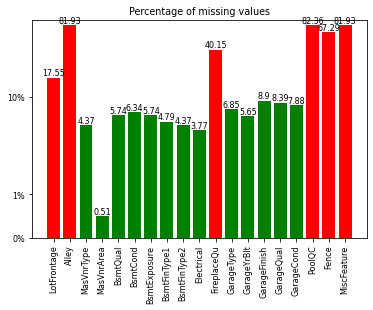

<Figure size 720x432 with 0 Axes>

In [55]:
# Get percentages of missing values for columns with missing values
plot_percentages_of_missing_values(df)

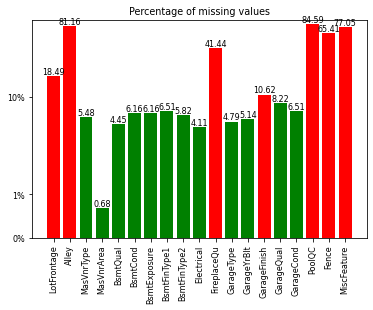

<Figure size 720x432 with 0 Axes>

In [56]:
plot_percentages_of_missing_values(df_test)

## Remove columns with many missing values (depending on the threshold):

In [57]:
# Remove columns that has more that 10% missing values (columns_with_many_missing_values)
columns_with_missing_values, columns_with_many_missing_values = get_columns_with_many_missing_values(df, percent_missing_threshold = 10)
print("columns_with_many_missing_values which we remove from the datasets:\n", columns_with_many_missing_values)
df = remove_columns(df, columns_with_many_missing_values)
df_test = remove_columns(df_test, columns_with_many_missing_values)

columns_with_many_missing_values which we remove from the datasets:
 ['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


## Numeric Columns




In [58]:
# Get the numeric columns of the dataset (including SalePrice which is the target column)
df_numeric = df.select_dtypes(include = ['float64', 'int64'])

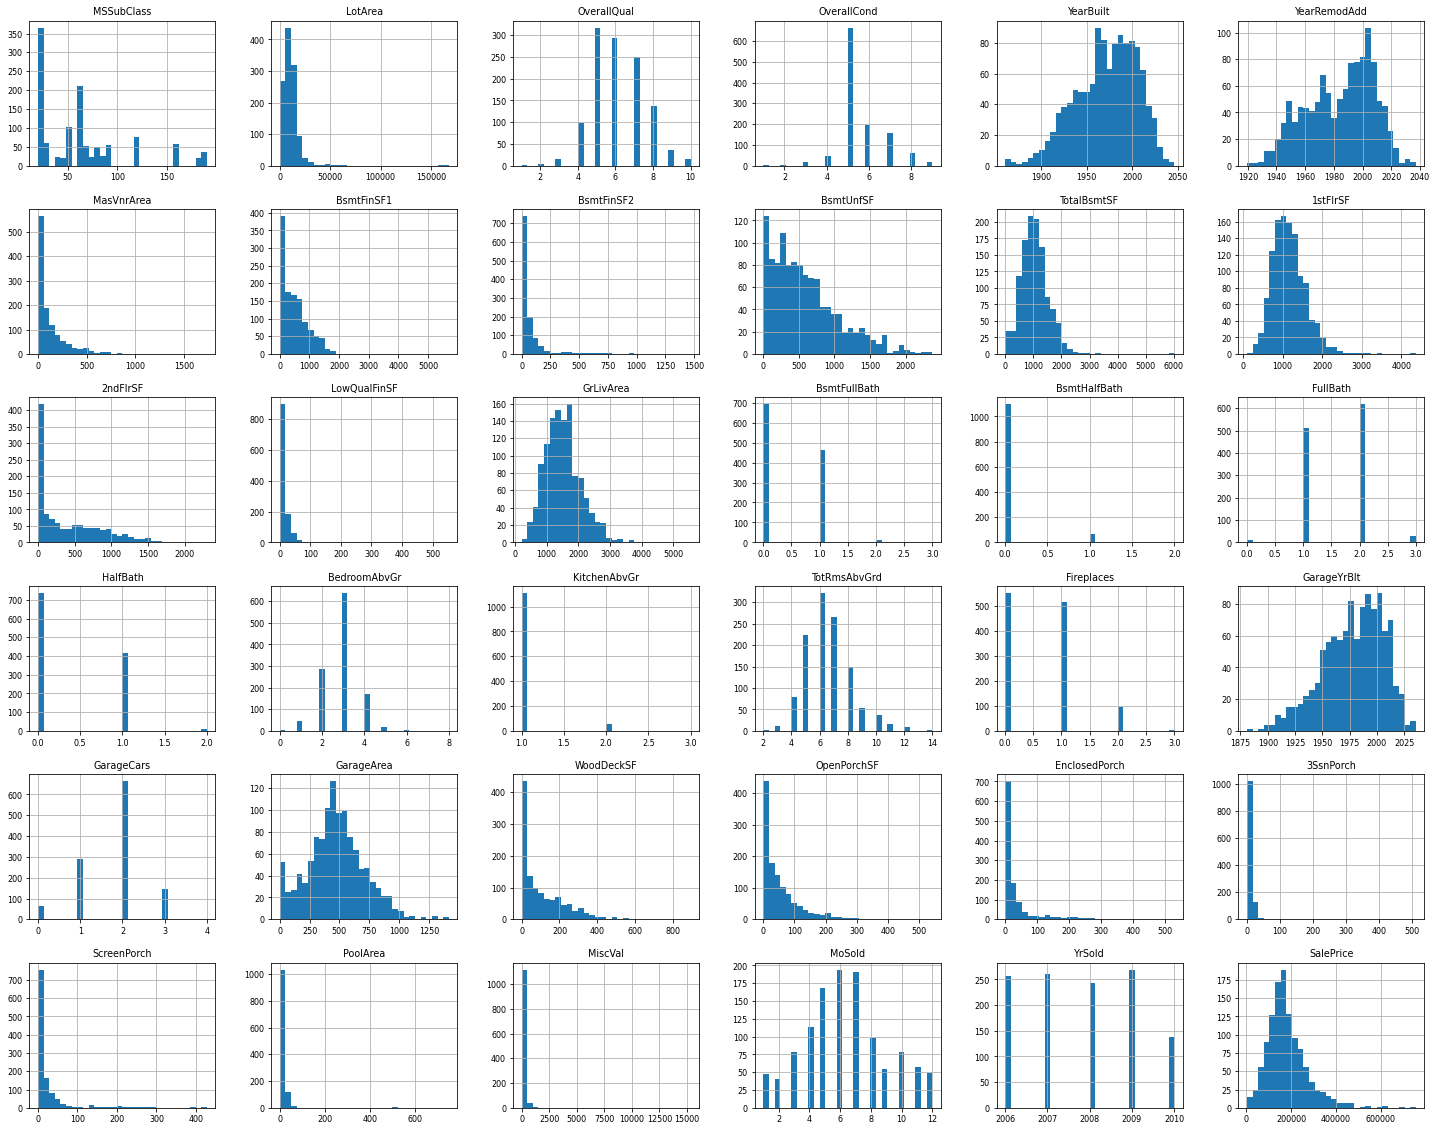

In [59]:
# Create a Histogram for each of the numeric columns
df_numeric.hist(bins=30, figsize=(25, 20));

In [60]:
# Get the normally distributed columns of the data using a p-value test (Shapiro-Wilk test)
normally_distributed_columns = get_normally_distributed_columns(df_numeric, alpha=0.05)
print("normally_distributed_columns:\n",normally_distributed_columns)

normally_distributed_columns:
 ['MasVnrArea', 'GarageYrBlt']


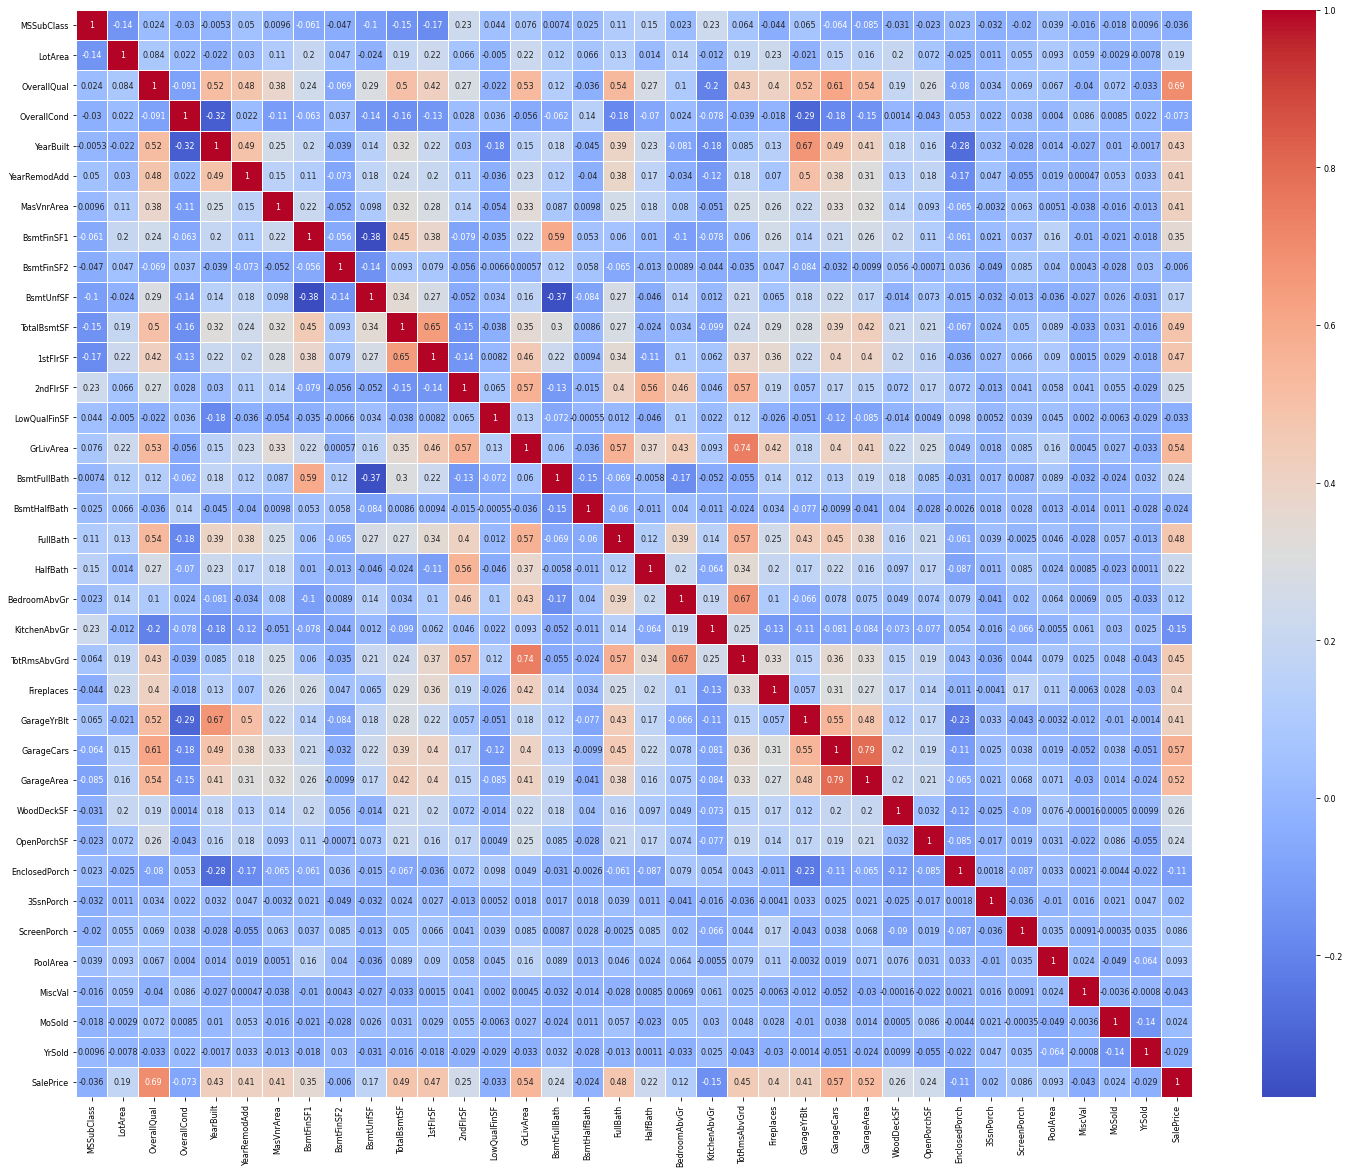

In [61]:
# Create a Correlation matrix for the numeric columns (including SalePrice which is the target column)
plt.subplots(figsize=(25,20))
sns.heatmap(df_numeric.corr(),cmap='coolwarm',linecolor='white',linewidths=1, annot = True);

In [62]:
# Separate the SalePrice colummn (which is the target column) from the train dataset
df_target = df["SalePrice"].copy()
df = df.drop(columns= ["SalePrice"])
df

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,12976.322830,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,7,5,2018.022763,1997.967142,Gable,CompShg,VinylSd,VinylSd,BrkFace,136.767389,Gd,TA,PConc,Gd,TA,No,GLQ,573.264362,Unf,0.000000,738.647192,1009.625953,Floor,Ex,Y,SBrkr,892.900140,785.910926,9.198647,1745.422665,0,0,2,1,3,1,Ex,7,Maj1,1,Attchd,2016.297743,RFn,2,522.699377,TA,TA,Y,0.000000,96.324158,24.723705,255.882821,0.000000,0.000000,296.249343,5,2008,ConLD,Normal
1,80,RL,15594.194520,Pave,IR2,Bnk,AllPub,Inside,Sev,NAmes,Norm,Norm,1Fam,2.5Fin,5,8,1940.100777,1994.519936,Gable,CompShg,Wd Sdng,Wd Sdng,None,183.575823,TA,TA,PConc,TA,TA,No,LwQ,891.848313,Unf,198.861197,234.663303,453.223513,GasA,Ex,Y,SBrkr,998.353598,464.358378,427.358195,2372.782821,0,0,2,1,4,1,Gd,8,Min1,1,Detchd,1951.179079,Unf,1,379.742975,Po,TA,N,244.144081,34.964038,8.195455,15.525909,0.000000,0.000000,254.008897,7,2008,ConLD,Normal
2,20,RL,12391.795260,Pave,IR3,Lvl,AllPub,FR3,Gtl,Sawyer,RRNn,Norm,1Fam,1Story,5,5,1959.392421,1971.914206,Gable,WdShake,MetalSd,MetalSd,BrkFace,31.000000,TA,Gd,CBlock,Ex,Po,NaN,BLQ,163.946824,NaN,130.753961,135.009580,1001.223068,Wall,TA,Y,SBrkr,989.873963,265.695973,0.000000,1312.052013,0,0,1,0,3,1,TA,5,Sev,0,Detchd,1960.104117,RFn,1,317.916621,TA,Fa,Y,20.406826,11.168310,0.000000,22.703114,59.679256,0.000000,188.143817,2,2010,WD,Normal
3,50,RM,1936.000000,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2.5Unf,4,6,1991.475740,1971.721880,Gable,CompShg,CemntBd,CmentBd,Stone,62.585902,TA,TA,CBlock,Fa,TA,Av,BLQ,85.096095,GLQ,395.897405,0.000000,302.637189,Grav,Gd,Y,Mix,507.743400,53.378960,35.895382,650.802497,1,0,1,0,1,1,TA,3,Typ,0,NaN,NaN,NaN,0,0.000000,NaN,Ex,Y,0.000000,0.000000,39.565928,8.183379,23.605141,34.640056,0.000000,12,2007,WD,Normal
4,20,RL,25084.792140,Pave,IR3,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1971.109318,1967.476198,Hip,CompShg,VinylSd,Plywood,BrkFace,243.588810,TA,Po,CBlock,TA,NaN,No,Rec,1004.712532,Rec,48.583971,400.573310,1241.025288,GasA,Fa,Y,SBrkr,1302.997115,225.049473,0.000000,717.419057,1,0,1,0,3,1,TA,6,Typ,0,Attchd,1994.059814,RFn,2,363.559443,TA,TA,Y,14.848224,0.000000,40.089628,7.065954,61.997208,0.000000,0.000000,5,2010,COD,Abnorml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,120,RH,4230.000000,Pave,Reg,Lvl,AllPub,Corner,Mod,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2003.806003,2013.038906,Gable,WdShake,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,TA,Gd,No,Unf,99.341803,GLQ,0.000000,1561.607657,1576.514518,GasA,Ex,Y,SBrkr,1498.052011,33.283964,0.000000,1546.914286,0,0,2,0,2,1,Gd,5,Typ,1,Attchd,2014.064841,RFn,2,676.090948,TA,TA,Y,0.000000,236.866433,10.690208,0.000000,0.000000,0.000000,20.778427,4,2007,New,Partial
1164,30,RL,24067.493620,Pave,Reg,HLS,AllPub,FR2,Sev,Gilbert,Norm,Feedr,1Fam,2.5Fin,7,5,2001.267888,2010.251726,Flat,CompShg,VinylSd,Other,None,0.000000,Gd,TA,PConc,Ex,Gd,NaN,Unf,0.000000,Unf,83.665788,1168.912665,1135.390447,Grav,Ex,Y,SBrkr,859.351082,1174.200345,0.000000,175

## Categorical Columns

##### Before we created the notebook, we went over the datasets and the explanation about the columns in the Readme.txt file in order to decide how to handle each of the columns so that we could use them to run the models. We created the handling_collumns_in_the_dataset_checklist.xlsx to both arange the info in an ordered manner and also to use it to divide the columns into their appropriate groups. It mainly adresses the handling methods of the categorical columns and of the columns with missing values.

Get columns checklist excel file that we created to list handling methods for categorical columns into a df


In [63]:
df_handling_methods = pd.read_excel(DATASET_GITHUB_MAIN_URL.format(filename=COLUMNS_HANDLING_EXCEL), index_col=None, header=0)
print(df_handling_methods["Handling Method"].value_counts(), "\n\n", "df_handling_methods:")
df_handling_methods.head()

No action                                34
Ordinal                                  17
OHE                                      14
Removing column - more that 10% Nulls     6
Binary                                    2
OHE + OR with condition2                  1
OHE + OR with condition1                  1
OHE + OR with Exterior2nd                 1
OHE + OR with Exterior1st                 1
OHE + OR with BsmtFinType2                1
OHE + OR with BsmtFinType1                1
Name: Handling Method, dtype: int64 

 df_handling_methods:


,Col Index,Column Name,Handling Method,Missing values handling,Additional Handling Info
0,0,MSSubClass,OHE,No missing values,NaN
1,1,MSZoning,OHE,No missing values,NaN
2,2,LotFrontage,Removing column - more that 10% Nulls,Removing column - more that 10% Nulls,NaN
3,3,LotArea,No action,No missing values,NaN
4,4,Street,Binary,No missing values,"1 - Pave, 0 - Grvl"


Get columns of each handling method into an array


In [64]:
Ordinal_columns = df_handling_methods["Column Name"][df_handling_methods["Handling Method"] == "Ordinal"].values.tolist()
OHE_columns = df_handling_methods["Column Name"][df_handling_methods["Handling Method"] == "OHE"].values.tolist()
Binary_columns = df_handling_methods["Column Name"][df_handling_methods["Handling Method"] == "Binary"].values.tolist()
Pairs_of_OHE_columns = [["Condition1", "Condition2"], ["Exterior1st", "Exterior2nd"], ["BsmtFinType1", "BsmtFinType2"]]

Create a rankings dictionary for converting categorical columns to Ordinal or Binary


In [65]:
rankings_dict = { # Ordinal columns
                  "LotShape" : {"Reg":0, "IR1":1, "IR2":2, "IR3":3},
                  "LandContour": {"Low":0, "HLS":1, "Bnk":2, "Lvl":3},
                  "Utilities": {"ELO":0, "NoSeWa":1, "NoSewr":2, "AllPub":3},
                  "LandSlope": {"Gtl":0, "Mod":1, "Sev":2},
                  "HouseStyle": {"1Story":1, "1.5Unf":1.25, "1.5Fin": 1.5,"2Story":2, "2.5Unf":2.25, "2.5Fin": 2.5, "SFoyer":3, "SLvl":3.5},
                  "ExterQual": {"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "ExterCond": {"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "BsmtQual": {np.nan:0, "Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "BsmtCond": {np.nan:0, "Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "BsmtExposure": {np.nan:0, "No":1, "Mn":2, "Av":3, "Gd": 4},
                  "HeatingQC": {"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "KitchenQual": {"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "Functional": {"Sal":1, "Sev":2, "Maj2":3, "Maj1": 4, "Mod":5, "Min2": 6, "Min1":7, "Typ":8},
                  "FireplaceQu": {np.nan:0,"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "GarageFinish": {np.nan:0,"Unf":1, "RFn":2, "Fin":3},
                  "GarageQual": {np.nan:0,"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "GarageCond": {np.nan:0,"Po":1, "Fa":2, "TA":3, "Gd": 4, "Ex":5},
                  "PavedDrive": {"N":0,"P":1, "Y":2},
                  "PoolQC": {np.nan:0, "Fa":1, "TA":2, "Gd": 3, "Ex":4},                  
                  # Binary columns
                  "Street": {"Grvl":0, "Pave":1},
                  "CentralAir": {"N":0, "Y":1},
                }

###### We made the HouseStyle column conversion to ordinal based on the number of floors, where if the property is unfinished it loses 0.25 from it's value ("1.5Unf", "2.5Unf"), and "SFoyer", "SLvl" got values of 3, 3.5 respectively

Convert categorical columns to Ordinal or binary

In [66]:
ordinal_and_binary_columns = Ordinal_columns + Binary_columns
df = convert_column_to_ordinal_or_binary(df, ordinal_and_binary_columns, rankings_dict)
df_test = convert_column_to_ordinal_or_binary(df_test, ordinal_and_binary_columns, rankings_dict)
df[ordinal_and_binary_columns].head(10)
df_test[ordinal_and_binary_columns].head(10)

,LotShape,LandContour,Utilities,LandSlope,HouseStyle,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive,Street,CentralAir
0,0,3,3,0,1.25,3,3,3,3,1,5,3,6,2,3,3,2,1,1
1,1,3,3,0,2.00,2,3,5,3,3,5,4,8,2,3,3,2,1,0
2,0,3,3,0,1.25,3,3,3,3,1,2,4,8,1,3,3,0,1,1
3,1,3,1,0,1.00,3,4,3,3,2,5,4,8,0,3,3,2,1,1
4,0,3,3,0,1.00,4,3,4,3,1,5,4,4,2,3,3,2,0,0
5,1,0,3,1,1.00,3,1,4,3,3,3,3,8,1,3,3,2,1,1
6,0,3,3,0,1.00,3,3,3,3,4,5,5,8,2,3,3,2,0,1
7,1,3,3,2,1.00,3,3,3,3,0,4,3,8,0,3,4,2,1,1
8,1,2,3,0,2.00,3,3,3,3,0,4,3,8,1,3,3,2,1,1
9,0,3,3,0,1.50,3,3,2,3,1,3,3,7,1,5,3,2,1,1


Create OHE columns from categorical columns and add them to the datasets

In [67]:
df = one_hot_encoding(df, OHE_columns)
df_test = one_hot_encoding(df_test, OHE_columns)

Handle the columns "Exterior1st" and "Exterior2nd" so that their values will be corresponding. <u>Brick Common</u> is denoted by "BrkComm" in Exterior1st and by "Brk Cmn" in Exterior2nd, and <u>Cement Board</u> is denoted by "CemntBd" in Exterior1st and by "CmentBd" in Exterior2nd. We'll modify the values in the column Exterior2nd


In [68]:
df["Exterior2nd"] = df["Exterior2nd"].replace("Brk Cmn", "BrkComm")
df["Exterior2nd"] = df["Exterior2nd"].replace("CmentBd", "CemntBd")
df_test["Exterior2nd"] = df_test["Exterior2nd"].replace("Brk Cmn", "BrkComm")
df_test["Exterior2nd"] = df_test["Exterior2nd"].replace("CmentBd", "CemntBd")

Handle the special case of pairs with similar categorical columns, and add the created OHE columns for them to the datasets

In [69]:
df = one_hot_encoding_pairs(df, Pairs_of_OHE_columns)
df_test = one_hot_encoding_pairs(df_test, Pairs_of_OHE_columns)

## Prepare columns to remove from datasets

In [70]:
columns_to_remove = []
# Get correlated columns that we'd like to remove and add them to the columns_to_remove list
correlated_features = get_correlated_features(df_numeric, threshold = 0.7)
correlated_columns_to_remove = [tup[0] for tup in correlated_features] # We chose to remove the first out of every correlated feature (arbitrarily)
columns_to_remove.extend(correlated_columns_to_remove)
# Add original columns that were converted to OHE to the columns_to_remove list
columns_to_remove.extend(OHE_columns)
# Add original columns from Pairs_of_OHE_columns that were converted to OHE to the columns_to_remove list
combined_list = sum(Pairs_of_OHE_columns, []) # inserts all elements into a single one-dimensional list
columns_to_remove.extend(combined_list)
print("columns to remove from datasets:\n", columns_to_remove)

columns to remove from datasets:
 ['GrLivArea', 'GarageArea', 'MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'BldgType', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'BsmtFinType2']


## Remove columns from datasets

In [71]:
df = remove_columns(df, columns_to_remove)
df_test = remove_columns(df_test, columns_to_remove)
df

,LotArea,Street,LotShape,LandContour,Utilities,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_OHE_20,MSSubClass_OHE_30,MSSubClass_OHE_40,MSSubClass_OHE_45,MSSubClass_OHE_50,MSSubClass_OHE_60,MSSubClass_OHE_70,MSSubClass_OHE_75,MSSubClass_OHE_80,MSSubClass_OHE_85,MSSubClass_OHE_90,MSSubClass_OHE_120,MSSubClass_OHE_160,MSSubClass_OHE_180,MSSubClass_OHE_190,MSZoning_OHE_C (all),MSZoning_OHE_FV,MSZoning_OHE_RH,MSZoning_OHE_RL,MSZoning_OHE_RM,LotConfig_OHE_Corner,LotConfig_OHE_CulDSac,LotConfig_OHE_FR2,LotConfig_OHE_FR3,LotConfig_OHE_Inside,Neighborhood_OHE_Blmngtn,Neighborhood_OHE_Blueste,Neighborhood_OHE_BrDale,Neighborhood_OHE_BrkSide,Neighborhood_OHE_ClearCr,Neighborhood_OHE_CollgCr,Neighborhood_OHE_Crawfor,Neighborhood_OHE_Edwards,Neighborhood_OHE_Gilbert,Neighborhood_OHE_IDOTRR,Neighborhood_OHE_MeadowV,Neighborhood_OHE_Mitchel,Neighborhood_OHE_NAmes,Neighborhood_OHE_NPkVill,Neighborhood_OHE_NWAmes,Neighborhood_OHE_NoRidge,Neighborhood_OHE_NridgHt,Neighborhood_OHE_OldTown,Neighborhood_OHE_SWISU,Neighborhood_OHE_Sawyer,Neighborhood_OHE_SawyerW,Neighborhood_OHE_Somerst,Neighborhood_OHE_StoneBr,Neighborhood_OHE_Timber,Neighborhood_OHE_Veenker,BldgType_OHE_1Fam,BldgType_OHE_2fmCon,BldgType_OHE_Duplex,BldgType_OHE_Twnhs,BldgType_OHE_TwnhsE,RoofStyle_OHE_Flat,RoofStyle_OHE_Gable,RoofStyle_OHE_Gambrel,RoofStyle_OHE_Hip,RoofStyle_OHE_Mansard,RoofStyle_OHE_Shed,RoofMatl_OHE_ClyTile,RoofMatl_OHE_CompShg,RoofMatl_OHE_Membran,RoofMatl_OHE_Metal,RoofMatl_OHE_Roll,RoofMatl_OHE_Tar&Grv,RoofMatl_OHE_WdShake,RoofMatl_OHE_WdShngl,MasVnrType_OHE_BrkCmn,MasVnrType_OHE_BrkFace,MasVnrType_OHE_None,MasVnrType_OHE_Stone,Foundation_OHE_BrkTil,Foundation_OHE_CBlock,Foundation_OHE_PConc,Foundation_OHE_Slab,Foundation_OHE_Stone,Foundation_OHE_Wood,Heating_OHE_Floor,Heating_OHE_GasA,Heating_OHE_GasW,Heating_OHE_Grav,Heating_OHE_OthW,Heating_OHE_Wall,Electrical_OHE_FuseA,Electrical_OHE_FuseF,Electrical_OHE_FuseP,Electrical_OHE_Mix,Electrical_OHE_SBrkr,GarageType_OHE_2Types,GarageType_OHE_Attchd,GarageType_OHE_Basment,GarageType_OHE_BuiltIn,GarageType_OHE_CarPort,GarageType_OHE_Detchd,SaleType_OHE_COD,SaleType_OHE_CWD,SaleType_OHE_Con,SaleType_OHE_ConLD,SaleType_OHE_ConLI,SaleType_OHE_ConLw,SaleType_OHE_New,SaleType_OHE_Oth,SaleType_OHE_WD,SaleCondition_OHE_Abnorml,SaleCondition_OHE_AdjLand,SaleCondition_OHE_Alloca,SaleCondition_OHE_Family,SaleCondition_OHE_Normal,SaleCondition_OHE_Partial,Condition1_Condition2_OHE_Artery,Condition1_Condition2_OHE_Feedr,Condition1_Condition2_OHE_Norm,Condition1_Condition2_OHE_PosA,Condition1_Condition2_OHE_PosN,Condition1_Condition2_OHE_RRAe,Condition1_Condition2_OHE_RRAn,Condition1_Condition2_OHE_RRNe,Condition1_Condition2_OHE_RRNn,Exterior1st_Exterior2nd_OHE_AsbShng,Exterior1st_Exterior2nd_OHE_AsphShn,Exterior1st_Exterior2nd_OHE_BrkComm,Exterior1st_Exterior2nd_OHE_BrkFace,Exterior1st_Exterior2nd_OHE_CBlock,Exterior1st_Exterior2nd_OHE_CemntBd,Exterior1st_Exterior2nd_OHE_HdBoard,Exterior1st_Exterior2nd_OHE_ImStucc,Exterior1st_Exterior2nd_OHE_MetalSd,Exterior1st_Exterior2nd_OHE_Other,Exterior1st_Exterior2nd_OHE_Plywood,Exterior1st_Exterior2nd_OHE_Stone,Exterior1st_Exterior2nd_OHE_Stucco,Exterior1st_Exterior2nd_OHE_VinylSd,Exterior1st_Exterior2nd_OHE_Wd Sdng,Exterior1st_Exterior2nd_OHE_Wd Shng,Exterior1st_Exterior2nd_OHE_WdShing,BsmtFinType1_BsmtFinType2_OHE_ALQ,BsmtFinType1_BsmtFinType2_OHE_BLQ,BsmtFinType1_BsmtFinType2_OHE_GLQ,BsmtFinType1_BsmtFinType2_OHE_LwQ,BsmtFinType1_BsmtFinType2_OHE_Rec,BsmtFinType1_BsmtFinType2_OHE_Unf
0,12976.322830,1,0,3,3,0,3.50,7,5,2018.0

# 3. Filling Missing Values

#### Remove Outliers from the datasets before filling missing values using z-score, based on remaining normally distributed columns

In [72]:
# Remove outliers for training purposes, doesn't affect test set
normally_distributed_columns = list(set(normally_distributed_columns) - set(columns_with_many_missing_values) - set(columns_to_remove))
df, rows_to_keep = Outliers(df, normally_distributed_columns)
df_target = df_target[rows_to_keep]
df

,LotArea,Street,LotShape,LandContour,Utilities,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_OHE_20,MSSubClass_OHE_30,MSSubClass_OHE_40,MSSubClass_OHE_45,MSSubClass_OHE_50,MSSubClass_OHE_60,MSSubClass_OHE_70,MSSubClass_OHE_75,MSSubClass_OHE_80,MSSubClass_OHE_85,MSSubClass_OHE_90,MSSubClass_OHE_120,MSSubClass_OHE_160,MSSubClass_OHE_180,MSSubClass_OHE_190,MSZoning_OHE_C (all),MSZoning_OHE_FV,MSZoning_OHE_RH,MSZoning_OHE_RL,MSZoning_OHE_RM,LotConfig_OHE_Corner,LotConfig_OHE_CulDSac,LotConfig_OHE_FR2,LotConfig_OHE_FR3,LotConfig_OHE_Inside,Neighborhood_OHE_Blmngtn,Neighborhood_OHE_Blueste,Neighborhood_OHE_BrDale,Neighborhood_OHE_BrkSide,Neighborhood_OHE_ClearCr,Neighborhood_OHE_CollgCr,Neighborhood_OHE_Crawfor,Neighborhood_OHE_Edwards,Neighborhood_OHE_Gilbert,Neighborhood_OHE_IDOTRR,Neighborhood_OHE_MeadowV,Neighborhood_OHE_Mitchel,Neighborhood_OHE_NAmes,Neighborhood_OHE_NPkVill,Neighborhood_OHE_NWAmes,Neighborhood_OHE_NoRidge,Neighborhood_OHE_NridgHt,Neighborhood_OHE_OldTown,Neighborhood_OHE_SWISU,Neighborhood_OHE_Sawyer,Neighborhood_OHE_SawyerW,Neighborhood_OHE_Somerst,Neighborhood_OHE_StoneBr,Neighborhood_OHE_Timber,Neighborhood_OHE_Veenker,BldgType_OHE_1Fam,BldgType_OHE_2fmCon,BldgType_OHE_Duplex,BldgType_OHE_Twnhs,BldgType_OHE_TwnhsE,RoofStyle_OHE_Flat,RoofStyle_OHE_Gable,RoofStyle_OHE_Gambrel,RoofStyle_OHE_Hip,RoofStyle_OHE_Mansard,RoofStyle_OHE_Shed,RoofMatl_OHE_ClyTile,RoofMatl_OHE_CompShg,RoofMatl_OHE_Membran,RoofMatl_OHE_Metal,RoofMatl_OHE_Roll,RoofMatl_OHE_Tar&Grv,RoofMatl_OHE_WdShake,RoofMatl_OHE_WdShngl,MasVnrType_OHE_BrkCmn,MasVnrType_OHE_BrkFace,MasVnrType_OHE_None,MasVnrType_OHE_Stone,Foundation_OHE_BrkTil,Foundation_OHE_CBlock,Foundation_OHE_PConc,Foundation_OHE_Slab,Foundation_OHE_Stone,Foundation_OHE_Wood,Heating_OHE_Floor,Heating_OHE_GasA,Heating_OHE_GasW,Heating_OHE_Grav,Heating_OHE_OthW,Heating_OHE_Wall,Electrical_OHE_FuseA,Electrical_OHE_FuseF,Electrical_OHE_FuseP,Electrical_OHE_Mix,Electrical_OHE_SBrkr,GarageType_OHE_2Types,GarageType_OHE_Attchd,GarageType_OHE_Basment,GarageType_OHE_BuiltIn,GarageType_OHE_CarPort,GarageType_OHE_Detchd,SaleType_OHE_COD,SaleType_OHE_CWD,SaleType_OHE_Con,SaleType_OHE_ConLD,SaleType_OHE_ConLI,SaleType_OHE_ConLw,SaleType_OHE_New,SaleType_OHE_Oth,SaleType_OHE_WD,SaleCondition_OHE_Abnorml,SaleCondition_OHE_AdjLand,SaleCondition_OHE_Alloca,SaleCondition_OHE_Family,SaleCondition_OHE_Normal,SaleCondition_OHE_Partial,Condition1_Condition2_OHE_Artery,Condition1_Condition2_OHE_Feedr,Condition1_Condition2_OHE_Norm,Condition1_Condition2_OHE_PosA,Condition1_Condition2_OHE_PosN,Condition1_Condition2_OHE_RRAe,Condition1_Condition2_OHE_RRAn,Condition1_Condition2_OHE_RRNe,Condition1_Condition2_OHE_RRNn,Exterior1st_Exterior2nd_OHE_AsbShng,Exterior1st_Exterior2nd_OHE_AsphShn,Exterior1st_Exterior2nd_OHE_BrkComm,Exterior1st_Exterior2nd_OHE_BrkFace,Exterior1st_Exterior2nd_OHE_CBlock,Exterior1st_Exterior2nd_OHE_CemntBd,Exterior1st_Exterior2nd_OHE_HdBoard,Exterior1st_Exterior2nd_OHE_ImStucc,Exterior1st_Exterior2nd_OHE_MetalSd,Exterior1st_Exterior2nd_OHE_Other,Exterior1st_Exterior2nd_OHE_Plywood,Exterior1st_Exterior2nd_OHE_Stone,Exterior1st_Exterior2nd_OHE_Stucco,Exterior1st_Exterior2nd_OHE_VinylSd,Exterior1st_Exterior2nd_OHE_Wd Sdng,Exterior1st_Exterior2nd_OHE_Wd Shng,Exterior1st_Exterior2nd_OHE_WdShing,BsmtFinType1_BsmtFinType2_OHE_ALQ,BsmtFinType1_BsmtFinType2_OHE_BLQ,BsmtFinType1_BsmtFinType2_OHE_GLQ,BsmtFinType1_BsmtFinType2_OHE_LwQ,BsmtFinType1_BsmtFinType2_OHE_Rec,BsmtFinType1_BsmtFinType2_OHE_Unf
0,12976.322830,1,0,3,3,0,3.50,7,5,2018.0

## Fill missing values for columns with missing values that were not removed

In [73]:
# Discard columns that we removed or already filled missing values
columns_with_missing_values = list(set(columns_with_missing_values) - set(ordinal_and_binary_columns) - set(columns_to_remove))
# Fill the missing values using the mean of each column
df = Filling_the_missing_values(df, columns_with_missing_values)
df_test = Filling_the_missing_values(df_test, columns_with_missing_values)
df[columns_with_missing_values]

,MasVnrArea,GarageYrBlt
0,136.767389,2016.297743
1,183.575823,1951.179079
2,31.000000,1960.104117
3,62.585902,1977.988847
4,243.588810,1994.059814
...,...,...
1162,0.000000,1968.049653
1163,0.000000,2014.064841
1164,0.000000,2007.864167
1165,311.807567,1981.137012


# 4. Feature Engineering

#### <u>Feature #1</u> : Difference between the year the property were sold and built
How new is the property when sold? Intuitively, we suspect that when a property is newer, it is likely to raise the sale price


In [74]:
df["difference_between_sold_and_built"] = df["YrSold"] - df["YearBuilt"].astype(int)
df_test["difference_between_sold_and_built"] = df_test["YrSold"] - df_test["YearBuilt"].astype(int)

#### <u>Feature #2</u> : Was the property sold after the great recession started (December 2007)?
Since the years of the transactions are in the realm of the great reccession, it is important to notice which of them occured before and after this great historic event


In [75]:
month_year_sold_train = pd.to_datetime(dict(year=df["YrSold"], month=df["MoSold"], day=1)) #added a day parameter to compare between dates in the next line
df["sold_after_great_recession_started"] = (month_year_sold_train >= datetime.datetime(2007, 12, 1))*1 # multiplied by 1 to convert True and False values to 0's and 1's
month_year_sold_test = pd.to_datetime(dict(year=df_test["YrSold"], month=df_test["MoSold"], day=1)) #added a day parameter to compare between dates in the next line
df_test["sold_after_great_recession_started"] = (month_year_sold_test >= datetime.datetime(2007, 12, 1))*1 # multiplied by 1 to convert True and False values to 0's and 1's

https://www.federalreservehistory.org/essays/great-recession-of-200709

#### <u>Feature #3</u> : Overall Value, which is the product of the overall quality and the overall condition of the property
We would like to know a more accurate metric regarding the precieved value of a property and how it affects the sale price

In [76]:
df["overall_value"] = df["OverallQual"] * df["OverallCond"]
df_test["overall_value"] = df_test["OverallQual"] * df_test["OverallCond"]

#### <u>Feature #4</u> : Room Density, which is the number of rooms above ground (TotRmsAbvGrd) divided by the number of floors (HouseStyle after conversion to ordinal)
This indicates on how sparse a property's floor structure is, which might affect the price

In [77]:
df["room_density"] = df["TotRmsAbvGrd"] / df["HouseStyle"]
df_test["room_density"] = df_test["TotRmsAbvGrd"] / df_test["HouseStyle"]

In [78]:
df[["difference_between_sold_and_built", "sold_after_great_recession_started", "overall_value", "room_density"]]

,difference_between_sold_and_built,sold_after_great_recession_started,overall_value,room_density
0,-10,1,35,2.000000
1,68,1,40,3.200000
2,51,1,25,5.000000
3,16,1,24,1.333333
4,39,1,25,6.000000
...,...,...,...,...
1162,18,0,25,8.000000
1163,4,0,35,5.000000
1164,5,0,35,3.600000
1165,61,1,36,6.000000


In [79]:
df_test[["difference_between_sold_and_built", "sold_after_great_recession_started", "overall_value", "room_density"]]

,difference_between_sold_and_built,sold_after_great_recession_started,overall_value,room_density
0,62,0,56,4.0
1,21,0,40,4.5
2,113,0,49,4.8
3,30,1,40,6.0
4,2,1,40,7.0
...,...,...,...,...
287,15,0,24,5.0
288,57,1,42,6.0
289,7,0,30,3.5
290,66,1,30,5.0


# 5. Data Normalization

In [80]:
float_columns = df.select_dtypes(include = ['float64']).columns.values.tolist() # Take float columns of the remaining dataset
columns_to_normalize = list(set(float_columns) - set(columns_with_many_missing_values) - set(columns_to_remove)) # Get rid of removed columns
df[columns_to_normalize],std = Standardization(df[columns_to_normalize]) # Normalize only float columns that weren't removed from the datasets
df_test[columns_to_normalize] = std.transform(df_test[columns_to_normalize]) # Normalize the Test data set in the same way the train set was normalized (i.e. using the same fitted StandardScaler)
df_test[columns_to_normalize]

,HouseStyle,BsmtUnfSF,YearBuilt,2ndFlrSF,MasVnrArea,LowQualFinSF,3SsnPorch,ScreenPorch,EnclosedPorch,GarageYrBlt,BsmtFinSF1,WoodDeckSF,LotArea,PoolArea,YearRemodAdd,room_density,1stFlrSF,OpenPorchSF,TotalBsmtSF,MiscVal,BsmtFinSF2
0,-0.538464,-0.291298,-0.770947,-0.925498,-0.788029,0.320594,0.592167,0.346404,-0.542322,-0.200188,-1.109537,-0.042625,-0.995815,-0.241500,0.556738,-0.306011,-0.828347,1.284174,-0.097238,-0.258660,0.135941
1,0.480324,0.264815,0.431859,1.626012,2.111452,-0.306273,-0.310009,-0.429948,-0.542322,1.269717,-0.973189,0.912214,-0.451023,0.504495,0.906334,-0.015838,-0.066862,2.399155,0.456099,0.264039,-0.039413
2,-0.538464,0.195909,-2.300155,-0.925498,-0.788029,-0.233902,-0.310009,-0.446203,2.146007,-2.149388,-1.109537,-0.252484,0.201187,-0.257382,-1.260524,0.158265,-0.373114,-0.269412,-0.653305,-0.166921,-0.475100
3,-0.878060,-1.023228,0.277362,-0.732686,-0.573301,0.000895,-0.310009,-0.315232,-0.023728,-1.150181,-1.041944,2.770467,-0.098104,0.154948,0.441503,0.854680,-0.747892,0.064641,-0.053570,0.106243,3.952126
4,-0.878060,1.477514,1.080620,-0.925498,4.273674,-0.306273,1.264241,0.350900,0.671666,1.325503,0.378172,-0.127968,0.680412,-0.257382,0.121462,1.435025,1.371729,0.722543,1.366935,0.528867,-0.475100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,-0.878060,-0.308356,0.639353,-0.548175,-0.320203,0.380399,0.485732,-0.384277,0.643515,-0.835792,0.950509,-0.865442,0.102149,-0.061069,0.005968,0.274335,-0.848749,-0.759828,-0.618902,-0.258660,-0.372630
288,-0.878060,-0.233418,-0.525165,-0.925498,-0.788029,-0.306273,-0.310009,0.246832,1.492153,-0.044152,-0.125268,-0.181210,-0.212218,0.136578,1.152799,0.854680,1.196157,1.636682,-0.624364,-0.258660,-0.475100
289,0.480324,0.408371,0.876079,1.043992,-0.788029,-0.306273,-0.310009,-0.446203,-0.479565,1.176465,-1.109537,-0.865442,-0.164212,-0.257382,0.145618,-0.596183,-1.209440,-0.124439,-0.230252,0.240072,-0.387713
290,-0.878060,-1.269417,-0.789371,-0.684659,0.226817,-0.306273,-0.310009,0.315965,1.730652,-0.890344,-0.996203,1.617885,-0.180569,-0.212148,0.297692,0.274335,-0.277398,-0.817145,-0.190498,0.399750,5.584895


# 6. Training

In [81]:
X, y = df.values, df_target.values # Splitting the data

For hyper parameter tuning, a randomized search was made - the functions are in the "Training Functions" section at the top of the notebook. <br>The search part is commented out to save up exhaustive running time - The best hyper parametes (output of randomized search) are written below, and used.

We used the following commented code to find the best hyper parameters:

In [82]:
# print("starting xgboost")
# # xgboost:
# xgboost_model_search  = GS_xgboost(X,y)
# xgboost_model = xgboost_model_search.best_estimator_
# xgboost_model_params = xgboost_model_search.best_params_
# print("starting mlp")
# # MLP:
# mlp_model_search  = GS_mlp(X,y)
# mlp_model = mlp_model_search.best_estimator_
# mlp_model_params = mlp_model_search.best_params_
# print("starting rf")
# # RF:
# rf_model_search  = GS_rf(X,y)
# rf_model = rf_model_search.best_estimator_
# rf_model_params = rf_model_search.best_params_

##### The hyper parameters that we got are chosen for the models:

In [83]:
xgboost_model_params = {'colsample_bytree': 0.5779972601681014, 'learning_rate': 0.027425083650459835, 'max_depth': 137, 'n_estimators': 166, 'reg_alpha': 0.3005575058716044}
mlp_model_params = {'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'relu'}
rf_model_params = {'bootstrap': False, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 179}

In [84]:
xgboost_model_best = xgb.XGBRegressor(objective='reg:absoluteerror', **xgboost_model_params)
mlp_model_best = MLPRegressor(**mlp_model_params)
rf_model_best = RandomForestRegressor(**rf_model_params)

##### Comparing the results:

In [85]:
models_names = ["XGBoost", "MLP", "RF"]
best_models = [xgboost_model_best, mlp_model_best, rf_model_best]
for model, model_name in zip(best_models, models_names):
  model.fit(X, y)
  print(model_name, mean_absolute_error(y, model.predict(X)))

XGBoost 4581.856192321335
MLP 36747.49094963525
RF 9057.878508855407


### XGBOOST is chosen!

# 7. Explainable AI

### SHAP Value

A SHAP value determines how (and how much) each feature in our model contributes to the overall prediction (target). This method allows us to be able to better explain the model's behavior and improve our business understanding.

#### Global interpretability

In [86]:
explainer = shap.TreeExplainer(xgboost_model_best)
explanation = explainer(df)
shap_values = explanation.values

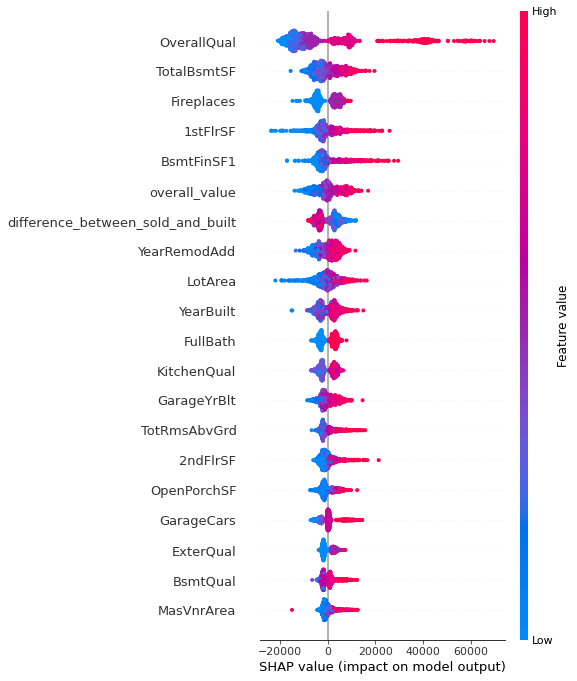

In [87]:
shap.summary_plot(shap_values, df)

##### Global explainabiity:
The purpouse of this explanation is to indicate what is the overall contribution to the predictions of each feature (how much each predictor contributes).
Each row shows the distribution of the SHAP value of each feature: each point is a datapoint, the color is set based on the positive/negative contribution.
<br>We can see that the top 3 most contributing features are: OverallQual, overall_value (Feature engineering), BsmtFinSF1.

### Local Interpretability

Starting from the mean price of the recieved properties (E(f(x))) each feature adds or subtracts its contribution, depending on its value, as can be seen from the plot above.

As instructed, we chose randomly 3 rows from the dataset for this part, using the following line of code:

In [88]:
# np.random.choice(df.shape[0], 3) -> ([655, 238, 6])

##### Sample 1

Target = 156473.5288


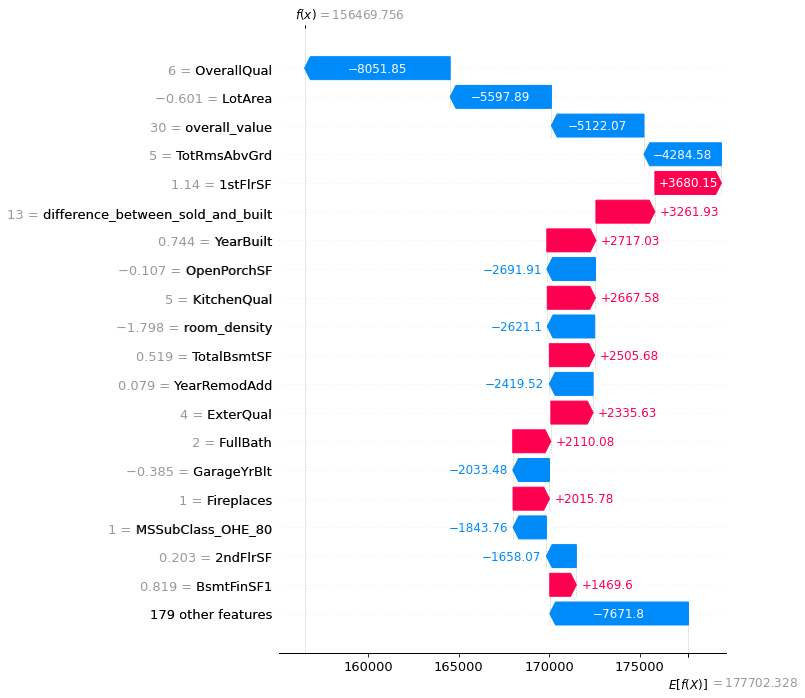

In [89]:
print(f"Target = {y[655]}")
shap.plots.waterfall(explanation[655], max_display=20)

##### Sample 1 explanation:
For This sample, it can be noticed that the top 3 contributing features are: Overall quality, overall value (Feature engineering) and LotArea, with a contibution of around -8K, -5.6K and -5.1K respectively.

##### Sample 2

Target = 106480.6186


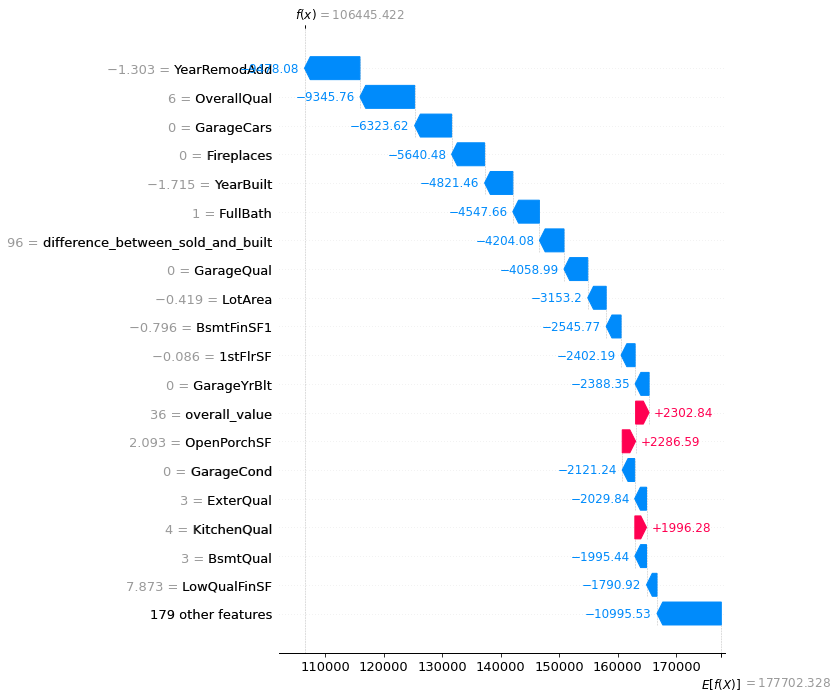

In [90]:
print(f"Target = {y[238]}")
shap.plots.waterfall(explanation[238], max_display=20)

##### Sample 2 explanation:
For This sample, it can be noticed that the top 3 contributing features are: Overall quality, YearsRemodAd and Year built, with a contibution of around -9.5K, -9.3K and -6.3K respectively.

##### Sample 3

Target = 307223.9581


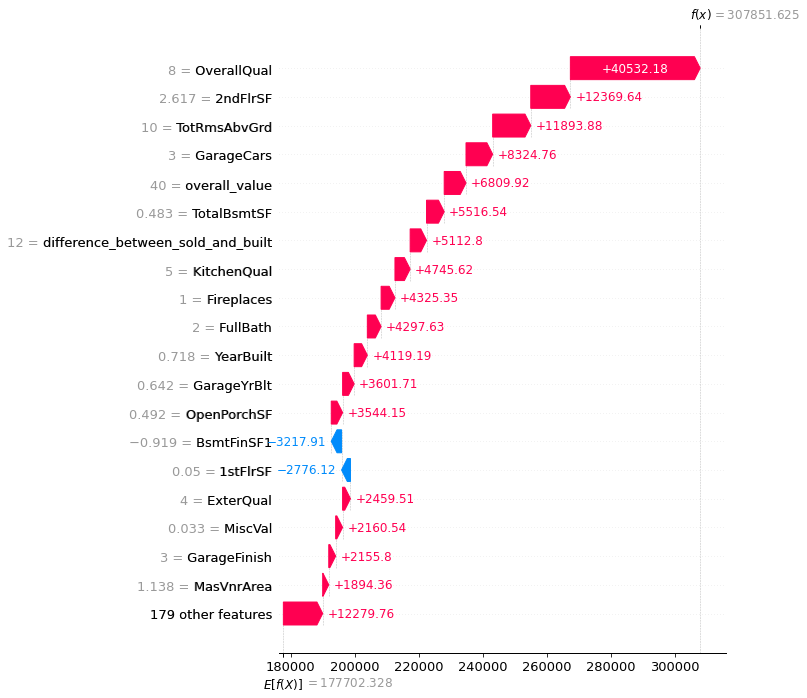

In [91]:
print(f"Target = {y[6]}")
shap.plots.waterfall(explanation[6], max_display=20)

##### Sample 3 explanation:
For This sample, it can be noticed that the top 3 contributing features are: Overall quality, 2ndFlrSF, and TotRmsAbvGrd, with a contibution of around 40.5K, 12.3K and 11.9K respectively.

# 8. Inference

In [ ]:
PREDICTION_FILENAME = "prediction.txt"

In [93]:
y_test_pred = xgboost_model_best.predict(df_test) # Make the predictions

In [ ]:
np.savetxt(PREDICTION_FILENAME, y_test_pred, fmt='%1.3f') # Export the results